%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 500px; /* or value of your choosing */
}
</style>

# Implementation and Comparison of three deep learning architectures in anomaly detection 

Security has always been of paramount importance in cyber and cyber-physical systems. On the other hand, integration of cyber systems with more sensitive infrastructures has incentivized hackers to trigger more and more attacks in recent years. This has resulted in more global investment on cybersecurity. Moreover, the amount of data flow is beyond human supervision capabilities. Hence, machine learning algorithms can be good candidates to build Intrusion Detection Systems (IDS).
<p>
In general, there are two types of IDS. Misuse-based in which the attacks signatures are known and anomaly-based that attempt to capture deviation from normal behaviour. In this project, our focus is on anomaly-based detection. The main idea of anomaly-based intrusion detection is to measure the deviation from normal behaviour. In case of network intrusion detection, we can use sequential traffic data to learn behaviours of the system. 
</p>
<p>
In this project we want to implement three well-known deep learning architectures, and compare their performance in intrusion detection task. The main question that this project is supposed to address is, which of these three architectures works better in detecting anomalies. 
</p>

##### Three Architectures:
<ol>
    <li>
        <b>Fully Connected Auto-Encoders:</b>
        Autoencoders try to model the distribution of normal data (without intrusion). The main idea is to feed the normal sequence of data into autoencoder. In this case, we expect to be able to reconstruct the data with low error. Otherwise, the error of reconstruction will be high, because the network is not trained on data in case of intrusion. 
        <figure text="center" style="text-align:center">
            <img src="images/fully_connected_autoencoder.png" width="300px"/>
            <figcaption>Figure 1 Fully Connected Auto-encoder network</figcaption>
        </figure>
    </li>
    <li>
        <b>LSTM:</b>
        The idea here is the same as Auto-encoder, i.e. we try to encode and then reconstruct the sequence with an architecture like Fig. 2.
        <figure text="center" style="text-align:center">
            <img src="images/LSTM_many_to_many.png" width="120px"/>
            <figcaption>Figure 2 Encoder-Decoder LSTM network</figcaption>
        </figure>
    </li>
    <li>
        <b>1-D Convolutional Network:</b>
        We know that 2D-CNN Models work well for image related tasks. But here as we are working on sequential statistical data, we should use 1D-CNN Models. Here first we encode the sequence using a convolutional encoder, then using de-convolution layers try to reconstruct the sequence. Idea is very similar to Fully connected auto-encoder but here we are using convolutional encoder and decoder.
    </li>
</ol>
In this notebook, we first try to find the best structure in each of three aforementioned architectures by tuning the parameters with respect to their power in reconstructing the sequences. Then we evaluate them in detecting the anomalies.

In rest of this notebook you can see the implementation of tuning, training and evaluation in more details and in the end we conclude which architecture works the best with our dataset.

##### Dataset:
We are using the synthetic data generated in [1] which contains 1000 normal sequences, each with length of 100. We use 900 of this data set for training and 100 for validation. For testing we have 142 labled sequences, that 50 of them are labled as anomalous sequences.

##### Anomally detection evaluation:
As usually the data in anomally detection tasks are heavily imbalanced, also, we care more to most suspicous sequences, we will use top-k ranked recall and precision to evaluate models power in anomaly detection. 

### Import packages

In [1]:
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, ZeroPadding1D, Cropping1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
import gc
import tensorflow as tf


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10823129447438044971
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1420898713
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8208876367481353555
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### Load data

In [5]:
with open('data_a.pickle', 'rb') as handle1:
    data = pickle.load(handle1)
    
training_data = data['training_data_A']
test_data = data['test_data_A']
test_labels = data['test_labels_A']
print(data.keys())

dict_keys(['training_data_A', 'test_data_A', 'anomalous_data_A', 'test_labels_A'])


### Data preparation

In [6]:
sequenceLen = training_data.shape[1]
trainDataSize = training_data.shape[0]
testDataSize = test_data.shape[0]
LSTMTraining_data = np.reshape(training_data, (trainDataSize,sequenceLen,1), order='C')
LSTMTest_data = np.reshape(test_data, (testDataSize,sequenceLen,1), order='C')

### Functions
Here we defined rankedPrecision() and rankedRecal() functions which are our evaluation functions in anomaly detection. The overall idea here is that, we first sort the samples loss from highest to lowest. Then, calculate precision and recall in top-K samples using definitions below:<br>
<p style="text-align:center">
$Precision=\frac{True Positive}{True Positive + False Positive}$<br/><br/>
$Recall=\frac{True Positive}{True Positive + False Negative}$<br/><br/>
</p>
As we know the number of anomalies in our test set, we pick K to be that number.

In [7]:
def rankedPrecision(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    precision = TP/(TP+FP)
    return precision
    
    
def rankedRecall(mse_labels):
    sorted_mse_label = mse_label[mse_label[:,0].argsort()[::-1]]
    totalNumberOfAnomalies = sum(sorted_mse_label[:,1] == 1)
    TP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 1)
    FP = sum(sorted_mse_label[0:totalNumberOfAnomalies,1] == 0)
    TN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 0)
    FN = sum(sorted_mse_label[totalNumberOfAnomalies:,1] == 1)
    recall = TP/(TP+FN)
    return recall

# show_curve() is for plotting training and validation losses
def show_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### LSTM
Here we defined a function to train LSTM using different parameters, later we try to tune them. In this notebook, we tuned number of LSTM layers and number of neurons.

In [27]:
def trainLSTM(numOfLayers, numOfNeurons, printSummary = 1, vrbs = 1, return_best = 0):
    
        print('Training model.')
        model = Sequential()

        model.add(LSTM(numOfNeurons, input_shape=(sequenceLen, 1), return_sequences=True))
        for j in range(0, numOfLayers - 1):
            model.add(LSTM(numOfNeurons, return_sequences=True))

        model.add(Dense(1))
        model.add(Activation("linear"))

        if(printSummary == True):
            model.summary()

        model.compile(optimizer='adam', # rmsprop
                  loss='mean_squared_error',
                  )

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
        callbacksArray = [es]
        if(return_best):
            mc = ModelCheckpoint('best_lstm.h5', monitor='val_loss', mode='min')
            callbacksArray = [es, mc]

        history=model.fit(LSTMTraining_data, LSTMTraining_data,
                        batch_size=180,
                        shuffle=True,
                        epochs=1000, 
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        verbose = vrbs,
                        )

        if(return_best):
            best_model = load_model('best_lstm.h5')
        returnModel = model
        if(return_best):
            returnModel = best_model
        return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### Tuning number of neurons
First we tune the number of neurons in LSTM layer. In basic model we considerd 1 LSTM layer and a Dense layer on top. We tried the range of 1 to 10 for the number of neurons:

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,11):
    numOfLayers = 1
    numOfNeurons = i 
    [model, validatoinLoss, numOfEpochs] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)# = [modelsLoss,validatoinLoss]
    modelsEpochs.append(numOfEpochs)

plt.plot(modelsLoss)
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
plt.show()

As you can see below, the loss is decreasing dramatically when we get from 1 to 4 neurons and then becomes flat with a slight rise in the end. As we cannot say for sure that it will increase after 10 neurons we tried to increase the number of neurons in our next test.

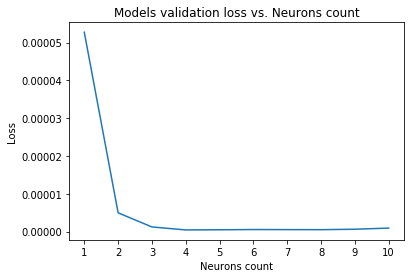

In [20]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. Neurons count')
plt.ylabel('Loss')
plt.xlabel('Neurons count')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
#plt.legend(['validation'], loc='upper left')
plt.show()

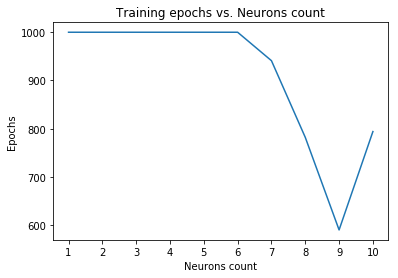

In [22]:
plt.plot(modelsEpochs)
#plt.plot(history.history['val_loss'])
plt.title('Training epochs vs. Neurons count')
plt.ylabel('Epochs')
plt.xlabel('Neurons count')
plt.xticks(np.arange(10),['1','2','3','4','5','6','7','8','9','10'])
#plt.legend(['validation'], loc='upper left')
plt.show()

#### More Neurons: 
Here we tried neurons count 10,20 ... 50 to make sure is the loss is worse with more neurons.

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    
    numOfLayers = 1
    numOfNeurons = i * 10 #np.power(2,i)
    #[best_model,loss_history] = trainLSTM(numOfLayers, numOfNeurons)
    [model, validatoinLoss, numOfEpochs,_] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)# = [modelsLoss,validatoinLoss]
    modelsEpochs.append(numOfEpochs)
    #K.clear_session()
    #del best_model
    #gc.collect()

As you can see in the figure below, more neurons cause worse results. Hence we picked the best number of neurons from the range below 10, in which the best was 4 neurons.

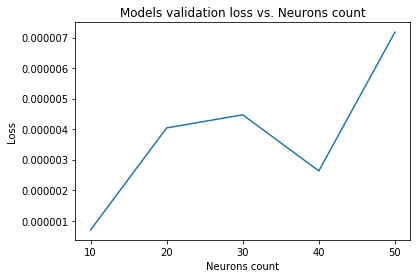

In [19]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. Neurons count')
plt.ylabel('Loss')
plt.xlabel('Neurons count')
plt.xticks(np.arange(5),['10','20','30','40','50'])
#plt.legend(['validation'], loc='upper left')
plt.show()

### Tuning Depth
In next step we try to pick the best Depth for LSTM layers from the range 1 to 5.

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    numOfLayers = i
    numOfNeurons = 4
    [model, validatoinLoss, numOfEpochs,_] = trainLSTM(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

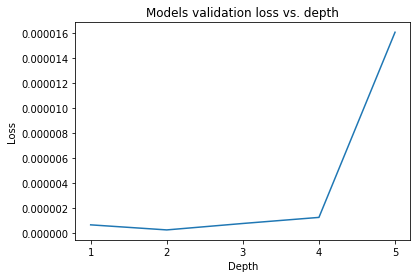

In [24]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(5), [1,2,3,4,5])
#plt.legend(['validation'], loc='upper left')
plt.show()

As you can see in the figure above, we had the best performance with 2 LSTM layers.

### Final LSTM training

Finally, we train the final LSTM architecture with 2 LSTM layers each with 4 neurons. 

In [ ]:
numOfLayers = 2
numOfNeurons = 4 #np.power(2,i)
#[best_model,loss_history] = trainLSTM(numOfLayers, numOfNeurons)
[model, validatoinLoss, numOfEpochs, history] = trainLSTM(numOfLayers, numOfNeurons)


### Final LSTM evaluation

Precision is:  1.0
Recall is:  1.0


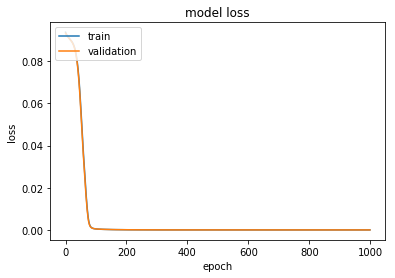

In [29]:
predicted = model.predict(LSTMTest_data)
mse = (np.square(LSTMTest_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
lstmPrecision = precision
lstmRecall = recall
print("precision is: ", precision)
print("Recall is: ", precision)
show_curve(history)

### Auto-encoder
Next architecture we want to use is the Auto-Encoder. Again we first defined a function to use in tuning.

In [24]:
def trainAutoencoder(numOfHiddenLayersInEncoder, NeuronsCountInFirstLayer, printSummary = 1, vrbs = 1, return_best = 0):
    
    print('Training model.')

    model = Sequential()
    
    #NeuronsCountInFirstLayer = 64
    model.add(Dense(NeuronsCountInFirstLayer, input_shape=(sequenceLen,), activation='relu'))
    for i in range(1,numOfHiddenLayersInEncoder):
        model.add(Dense(int(NeuronsCountInFirstLayer/np.power(2,i)), activation="relu"))
        
    for j in range(1,numOfHiddenLayersInEncoder):    
        model.add(Dense(int(NeuronsCountInFirstLayer/np.power(2,(numOfHiddenLayersInEncoder - j - 1))), activation="relu"))
        
    model.add(Dense(100, activation="linear"))

    if(printSummary == True):
            model.summary()

    model.compile(optimizer='adam',
        loss='mean_squared_error',
    )
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    callbacksArray = [es]
    if(return_best):
        mc = ModelCheckpoint('best_Autoencoder.h5', monitor='val_loss', mode='min')
        callbacksArray = [es, mc]

    history=model.fit(training_data, training_data,
                        batch_size=128,
                        shuffle=True,
                        epochs=1000, # Change this to at least 20 for final run
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        verbose = vrbs
                        )
    
    if(return_best):
        best_model = load_model('best_Autoencoder.h5')
        
    returnModel = model
    if(return_best):
        returnModel = best_model
    return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### Fully Connected Auto-encoder depth tuning
In this part we try to tune the Auto-Encoder depth. We used 1,3,5 and 7 hidden layers to find out which works the best.

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,5):
    numOfLayers = i
    numOfNeurons = 4
    [model, validatoinLoss, numOfEpochs,_] = trainAutoencoder(numOfLayers, numOfNeurons)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

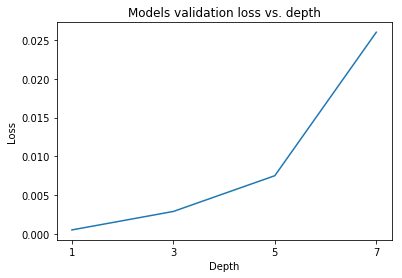

In [74]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. depth')
plt.ylabel('Loss')
plt.xlabel('Depth')
plt.xticks(np.arange(4), [1,3,5,7])
#plt.legend(['validation'], loc='upper left')
plt.show()

According to the figure above, it seems that the simplest model with just one hidden layer has the best performance.

### Final Auto-Encoder learning

In [ ]:
numOfHiddenLayers = 1
numOfNeurons = 64
[model, validatoinLoss, numOfEpochs, history] = trainAutoencoder(numOfHiddenLayers, numOfNeurons, return_best = 1)

### Final Auto-encoder evaluation

Precision is:  0.78
Recall is:  0.78


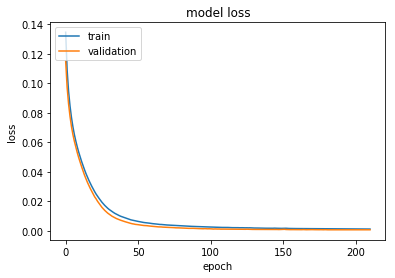

In [76]:
predicted = model.predict(test_data)
mse = (np.square(test_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
autoencoderPrecision = precision
autoencoderRecall = recall
print("Precision is: ", precision)
print("Recall is: ", precision)
show_curve(history)

### 1-D Convolutional Network

In [3]:
def train1DConv(numOfHiddenLayersInEncoder, FiltersCountInFirstLayer = 32, printSummary = 1, vrbs = 1, return_best = 0, filterSize = 3):
    numOfHiddenLayersInEncoder = numOfHiddenLayersInEncoder + 1
    model = Sequential()    
    poolingSize = 2
    numOfFiltersInEncoder = [FiltersCountInFirstLayer]
    paddedSequenceLen = 128
    encoderLayersFilterSizes = [paddedSequenceLen]
    model.add(ZeroPadding1D(14,input_shape=(sequenceLen,1)))
    model.add(Conv1D(int(FiltersCountInFirstLayer), filterSize, activation='relu', padding = 'same'))
    for i in range(1,numOfHiddenLayersInEncoder):
        model.add(MaxPooling1D(poolingSize, padding='same'))
        model.add(Conv1D(int(FiltersCountInFirstLayer*np.power(2,i)), filterSize, activation='relu', padding = 'same'))
        encoderLayersFilterSizes.append(int(np.ceil(paddedSequenceLen/np.power(2,i))))
        numOfFiltersInEncoder.append(int(FiltersCountInFirstLayer*np.power(2,i)))
    model.add(Flatten())
    model.add(Reshape((encoderLayersFilterSizes[-1], numOfFiltersInEncoder[-1])))
    for j in range(1,numOfHiddenLayersInEncoder):    
        model.add(Conv1D(numOfFiltersInEncoder[-j], filterSize, activation='relu', padding = 'same'))
        model.add(UpSampling1D(poolingSize))

    model.add(Conv1D(numOfFiltersInEncoder[0], filterSize, activation='relu', padding='same'))
    model.add(Conv1D(1, filterSize, activation='linear', padding='same'))
    model.add(Cropping1D(14))
    model.summary()

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  )

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    callbacksArray = [es]
    if(return_best):
        mc = ModelCheckpoint('best_1DConv.h5', monitor='val_loss', mode='min')
        callbacksArray = [es, mc]

    history=model.fit(LSTMTraining_data, LSTMTraining_data,
                        batch_size=128,
                        epochs=1000, 
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        )
    if(return_best):
        best_model = load_model('best_1DConv.h5')
        
    returnModel = model
    if(return_best):
        returnModel = best_model
    return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### 1-D Convolutional Network Depth tune

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    numOfLayers = i
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

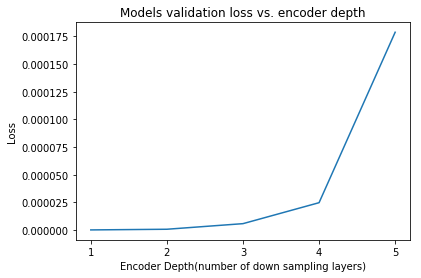

In [293]:
plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. encoder depth')
plt.ylabel('Loss')
plt.xlabel('Encoder Depth(number of down sampling layers)')
plt.xticks(np.arange(5), [1,2,3,4,5])
#plt.legend(['validation'], loc='upper left')
plt.show()

### 1-D Convolutional Network filter size tuning

In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(3,10,2):
    numOfLayers = 1
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

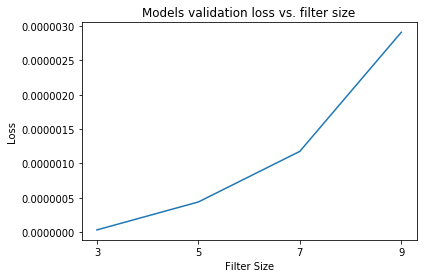

In [297]:
plt.plot(modelsLoss)
plt.title('Models validation loss vs. filter size')
plt.ylabel('Loss')
plt.xlabel('Filter Size')
plt.xticks(np.arange(4), [3,5,7,9])
plt.show()

### 1-D Convolutional Network first layer filter count tuning


In [ ]:
modelsLoss = []
modelsEpochs = []
for i in range(1,10):
    numOfLayers = 1
    filtersCountInFirstLayer = np.power(2,i)
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

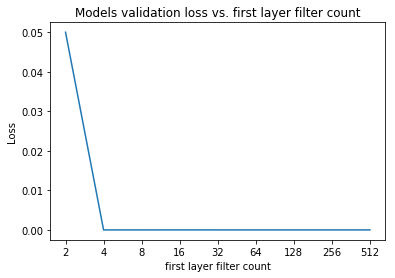

In [9]:
plt.plot(modelsLoss)
plt.title('Models validation loss vs. first layer filter count')
plt.ylabel('Loss')
plt.xlabel('first layer filter count')
plt.xticks(np.arange(9), [2,4,8,16,32,64,128,256,512])
plt.show()

First, I tried different filter counts ranged from 2 to 512 (powers of 2). As you can see in figure above, using filter size 2 is not enough and results in the worst performance. As the different between other filter counts is not clear here, I plotted range 4 to 512 in the next figure.

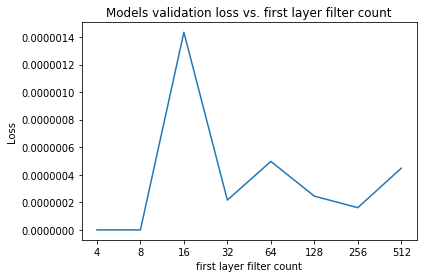

In [17]:
plt.plot(modelsLoss[1:])
plt.title('Models validation loss vs. first layer filter count')
plt.ylabel('Loss')
plt.xlabel('first layer filter count')
plt.xticks(np.arange(8), [4,8,16,32,64,128,256,512])
plt.show()

###### Plot in more detail:
As it is shown in figure above, we have the best performance in filter sizes 4 and 8. Although there is fluctuations in larger sizes results, all of them have worse performance (due lack of memory I could not try filter sizes more than 512. However, this does not seems to be a decsending trend). 

### Final 1D Convolutional Network learning
Now it is time to train our final model using the parameters that we found before:

In [ ]:
numOfLayers = 1
filtersCountInFirstLayer = 4
[model, validatoinLoss, numOfEpochs, history] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)

### 1-D Convolutional Network Final evaluation

Precision is:  1.0
Recall is:  1.0


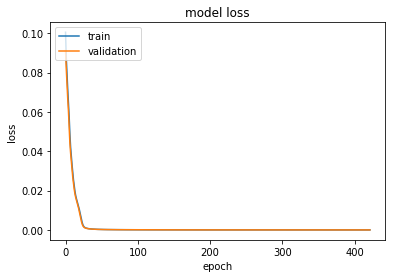

In [19]:
predicted = model.predict(LSTMTest_data)
mse = (np.square(LSTMTest_data - predicted)).mean(axis=1)
mse = mse.reshape(testDataSize)
reshaped_test_labels = test_labels.reshape(testDataSize)
mse_label = np.vstack((mse, reshaped_test_labels)).T
precision = rankedPrecision(mse_label)
recall = rankedRecall(mse_label)
convPrecision = precision
convRecall = recall
print("Precision is: ", precision)
print("Recall is: ", precision)
#history.history['loss']
show_curve(history)

### Conclusion

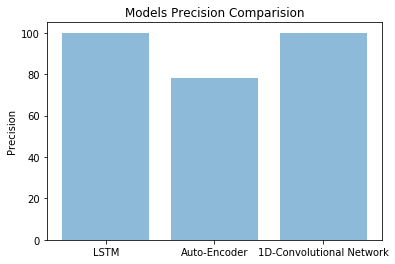

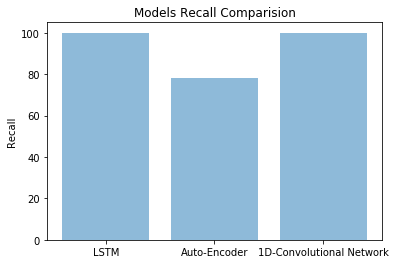

In [33]:
objects = ('LSTM', 'Auto-Encoder', '1D-Convolutional Network')
y_pos = np.arange(len(objects))
performance = [lstmPrecision,autoencoderPrecision,convPrecision]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Precision')
plt.title('Models Precision Comparision')
 
plt.show()

objects = ('LSTM', 'Auto-Encoder', '1D-Convolutional Network')
y_pos = np.arange(len(objects))
performance = [lstmRecall,autoencoderRecall,convRecall]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Recall')
plt.title('Models Recall Comparision')
 
plt.show()

As you can see in images above, both LSTM and one dimensional convolutional network have a great performance on detecting anomalies in our dataset. However, this does not say that these models are outperforming Auto-Encoder in anomaly detection and all the results are espesific to this dataset. Because we are just using a relatively simple synthetic dataset with one feature consisting of 0s and 1s. In real world there are more complex patterns which might be harder to learn. For future works, we should try these models (of course after tuning them well) on different datasets. Other thing that we should mention here is that, there are more parameters to tune in each of these architectures, like number of Dense layers in LSTM network, Or different optimizers in Auto-Encoder that we could not test all of them due lack of time but in more complex tasks it might be necessary to do that.

### References
<ol>
    <li>
      O. Gorokhov, M. Petrovskiy, and I. Mashechkin, "Convolutional neural networks for unsupervised anomaly detection in text data," in International Conference on Intelligent Data Engineering and Automated Learning, 2017, pp. 500-507.  
    </li>
    <li>
      D. Kwon, K. Natarajan, S. C. Suh, H. Kim, and J. Kim, "An empirical study on network anomaly detection using convolutional neural networks," in 2018 IEEE 38th International Conference on Distributed Computing Systems (ICDCS), 2018, pp. 1595-1598. 
    </li>
    <li>
      D. Sovilja, P. Budnaraina, S. Sanner, G. Salmonb, and M. Raob, "A Comparative Evaluation of Unsupervised Deep Learning Techniques for Intrusion Detection in Sequential Data Streams." 
    </li>
</ol>